### Model: NasNetLarge

## Import Libraries & Load Data

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from data_loader import load_dir, split_data, create_dataset, data_augmentation

2024-08-07 17:08:53.497951: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 17:08:53.518552: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 17:08:53.617490: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 17:08:53.721383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 17:08:53.798559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# define 
classes = ['buildings', 'street']
train_dir = 'first_100/seg_train/seg_train'
test_dir = 'first_100/seg_test/seg_test'
max_images = 50  # Number of images per class

image_size=(331,331) #NASnet requires a larger image size
num_classes=2

In [3]:
# Load images and labels
train_images, train_labels = load_dir(train_dir, classes, max_images, image_size)
test_images, test_labels = load_dir(test_dir, classes, max_images, image_size)

In [4]:
# Split the training data into train and validation sets
train_images, train_labels, val_images, val_labels = split_data(train_images, train_labels, val_split=0.2)

In [5]:
# Create train and validation datasets
train_ds = create_dataset(train_images, train_labels, batch_size=10)
val_ds = create_dataset(val_images, val_labels, batch_size=10)

test_ds = create_dataset(test_images, test_labels, batch_size=10)

## Train Model

In [6]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of NASNetLarge and freeze the weights
    backbone = keras.applications.NASNetLarge(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.nasnet.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [7]:
model = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

In [8]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4), # changed to updated optimizer API
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - acc: 0.5240 - loss: 0.6401 - val_acc: 0.6625 - val_loss: 0.5693
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 9s/step - acc: 0.5976 - loss: 0.5689 - val_acc: 0.8625 - val_loss: 0.5117
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 69s 10s/step - acc: 0.8175 - loss: 0.4947 - val_acc: 0.8625 - val_loss: 0.4713
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 10s/step - acc: 0.8449 - loss: 0.4535 - val_acc: 0.9250 - val_loss: 0.4321
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - acc: 0.8673 - loss: 0.4593 - val_acc: 0.9250 - val_loss: 0.3986
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 11s/step - acc: 0.8992 - loss: 0.4126 - val_acc: 0.9375 - val_loss: 0.3705
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 10s/step - acc: 0.9448 - loss: 0.3563 - val_acc: 0.9375 - val_loss: 0.3456
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 12s/step - acc: 0.9559 - loss: 0.3298 - val_acc: 0.9375 - val_loss: 0.3240
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step - acc: 0.9214 - loss: 0.3220 - val

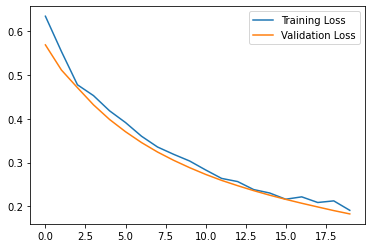

In [9]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

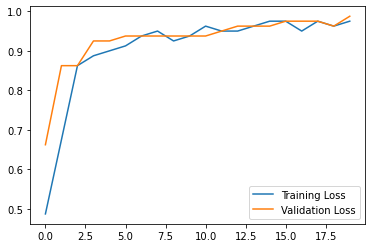

In [10]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [11]:
# save model

model_dir='Models'
os.makedirs(model_dir,exist_ok=True)

model_path=os.path.join(model_dir,'NASnetLarge.keras')
model.save(model_path)